In [693]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import seaborn as sns
import missingno as msno


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer

import folium


from folium.plugins import MarkerCluster, HeatMap, HeatMapWithTime



from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression 
from sklearn import linear_model
from branca.colormap import linear
from matplotlib.lines import Line2D
from sklearn.tree import DecisionTreeRegressor


from math import radians, sin, cos, sqrt, atan2

import statsmodels.api as sm    

from scipy.stats import ttest_ind


### Read Data ###

In [699]:
# Read Data
listings_data = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/listings.csv.gz')
geodata = gpd.read_file('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/neighbourhoods.geojson')
calendar_data = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/calendar.csv.gz')
reviews_df = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/reviews.csv.gz')

# Data Cleaning #

<Axes: >

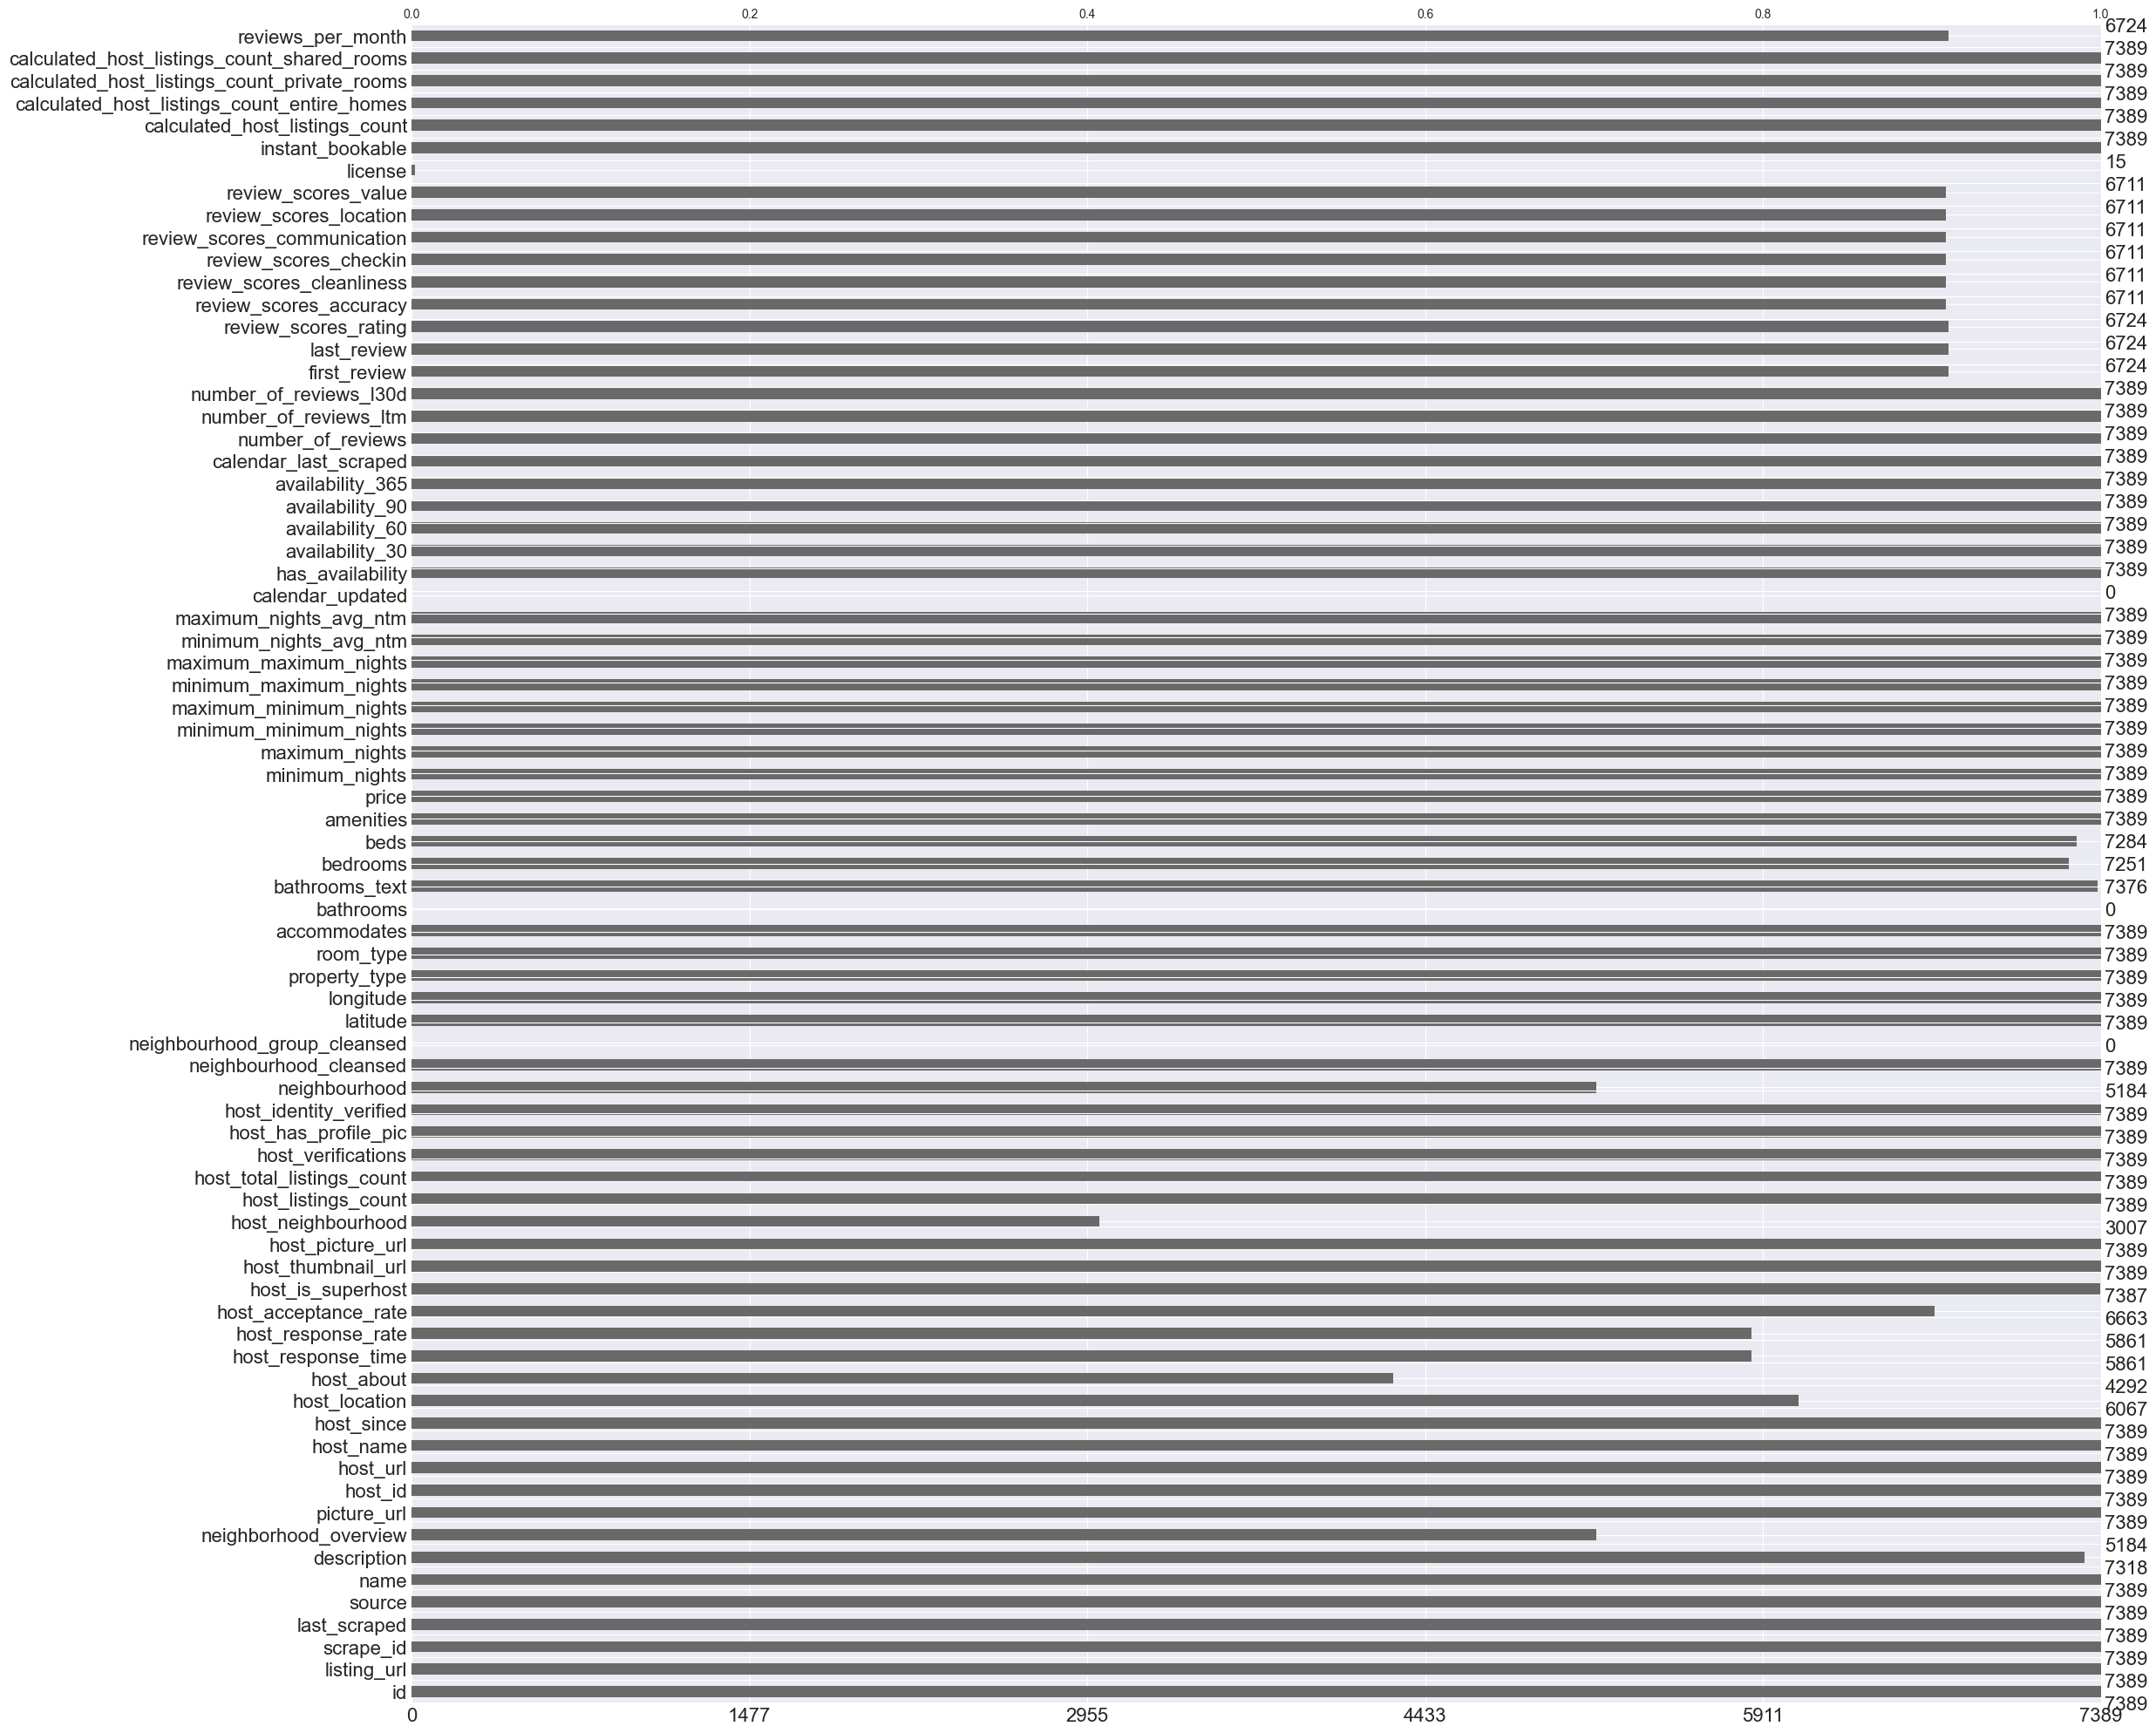

In [540]:
msno.bar(listings_data)

In [700]:
# Converting host response rate to float type
listings_data["host_response_rate"] = listings_data["host_response_rate"].str.replace("%", "")
listings_data["host_response_rate"] = pd.to_numeric(listings_data["host_response_rate"], downcast="integer")

# Converting host acceptance rate to float type
listings_data["host_acceptance_rate"] = listings_data["host_acceptance_rate"].str.replace("%", "")
listings_data["host_acceptance_rate"] = pd.to_numeric(listings_data["host_acceptance_rate"], downcast="integer")

# Converting host is superhost to float type
listings_data["host_is_superhost"] = listings_data["host_is_superhost"].str.replace("t", "1")
listings_data["host_is_superhost"] = listings_data["host_is_superhost"].str.replace("f", "0")
listings_data["host_is_superhost"] = pd.to_numeric(listings_data["host_is_superhost"], downcast="integer")

# Converting host identity verified to float type
listings_data["host_identity_verified"] = listings_data["host_identity_verified"].str.replace("t", "1")
listings_data["host_identity_verified"] = listings_data["host_identity_verified"].str.replace("f", "0")
listings_data["host_identity_verified"] = pd.to_numeric(listings_data["host_identity_verified"], downcast="integer")

# Converting price to float type
listings_data["price"] = listings_data["price"].str.replace("$", "")
listings_data["price"] = listings_data["price"].str.replace(",", "")
listings_data["price"] = pd.to_numeric(listings_data["price"], downcast="integer")



C:\Users\rohit\AppData\Local\Temp\ipykernel_3524\3040740758.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings_data["price"] = listings_data["price"].str.replace("$", "")


In [702]:
columns = ["neighbourhood_cleansed",
                          "property_type", 
                          "room_type",
                          "accommodates", 
                          "bedrooms", 
                          "beds",
                          "bathrooms_text",
                          "minimum_nights", 
                          "availability_30", 
                          "availability_60", 
                          "availability_90", 
                          "availability_365",
                          "latitude",
                          "longitude",
                          "number_of_reviews", 
                          "reviews_per_month", 
                          "review_scores_rating", 
                          "review_scores_accuracy", 
                          "review_scores_cleanliness",
                          "review_scores_checkin", 
                          "review_scores_communication", 
                          "review_scores_location", 
                          "review_scores_value", 
                          "host_response_time", 
                          "host_response_rate", 
                          "host_acceptance_rate",
                          "host_is_superhost",
                          "host_identity_verified",
                          "host_total_listings_count",
                          "amenities", 
                          "price"]

df=listings_data[columns]

##### Cleaning Data ######

# for neighbouthoodcleansed
# No null entries
# Remove Neighbourhood with less than 10 listings 
df = df.groupby("neighbourhood_cleansed").filter(lambda x: len(x)>10)
# create new column for average price of neighbourhood
# neighbourhood_data = listings_data.groupby("neighbourhood_cleansed")["price"].mean()

# list_of_neighbourhoods=list(neighbourhood_data.index)
# list_of_neighbourhoods_df=list(df["neighbourhood_cleansed"])
# average_price=list(neighbourhood_data)
# neighbourhood_mean_price=[]
# for neighbourhood_df in list_of_neighbourhoods_df:
#     for neighbourhood in list_of_neighbourhoods:
#         if(neighbourhood_df==neighbourhood):
#             index = list_of_neighbourhoods.index(neighbourhood)
#             neighbourhood_mean_price.append(average_price[index])
# df["neighbourhood_mean_price"]=neighbourhood_mean_price


# for property type
# No null entries
# Remove types with less than 10 entries
df = df.groupby("property_type").filter(lambda x: len(x)>=10)

# for room type
# No null entries

df_property = pd.get_dummies(df["property_type"])
df_room = pd.get_dummies(df["room_type"])
df_room_property= pd.concat([df_property,df_room], axis=1)
df=pd.concat([df,df_room_property], axis=1)
df = df.drop('property_type', axis=1)
df = df.drop('room_type', axis=1)
# for accommodates
# o null entries

# for bedroms
# Remove null entries
df = df[~pd.isnull(df["bedrooms"])]
# Remove more than 10 bedrooms
df = df[df["bedrooms"] <= 10]

# for beds
# Remove null entries
df = df[~pd.isnull(df["beds"])]
# Remove more than 16 beds
df = df[df["beds"] <= 16]

# for bathrooms
df = df[~pd.isnull(df["bathrooms_text"])]
df['no_of_bathrooms']=df.bathrooms_text.str.extract('([-+]?\d*\.?\d+)')
df = df[~pd.isnull(df["no_of_bathrooms"])]
df = df.drop('bathrooms_text', axis=1)
df["no_of_bathrooms"] = pd.to_numeric(df["no_of_bathrooms"], downcast='integer')


# for minimum nights
# No null entries
# Remove "Minimum Nights" above 30 except for multiples of 30 (corresponding to months)
df = df[(df["minimum_nights"]<=31) | (df["minimum_nights"].isin([60, 90, 120, 180]))]

# for availability 30
# No null entries

# for availability 60
# No null entries

# for availability 90
# No null entries

# for availability 365
# No null entries

# for number of reviews
# Remove null entries
df = df[~pd.isnull(df["number_of_reviews"])]

# for reviews per month
# Remove null entries
df = df[~pd.isnull(df["reviews_per_month"])]

# for review scores
# Remove null entries
df = df[~pd.isnull(df["review_scores_rating"])]
df = df[~pd.isnull(df["review_scores_accuracy"])]
df = df[~pd.isnull(df["review_scores_cleanliness"])]
df = df[~pd.isnull(df["review_scores_checkin"])]
df = df[~pd.isnull(df["review_scores_communication"])]
df = df[~pd.isnull(df["review_scores_location"])]
df = df[~pd.isnull(df["review_scores_value"])]


# for host response time
# Assign "a few days or more" to entries with NULL values for "Host Response Time"
df["host_response_time"].fillna("a few days or more", inplace=True)
df_host_response_time = pd.get_dummies(df["host_response_time"])
df=pd.concat([df,df_host_response_time], axis=1)
df = df.drop('host_response_time', axis=1)

# for host response rate
# Assign mean to entries with NULL values for "Host Response Rate"
df["host_response_rate"].fillna(listings_data["host_response_rate"].mean(), inplace=True)

df = df[~pd.isnull(df["host_acceptance_rate"])]

# for host total listings count
# No null entries

# for price
# No null entries
# Remove 0 entries
df = df[df["price"] > 0]
extprice = df['price'].quantile([0.025, 0.975])
low = extprice[0.025]
high = extprice[0.975]
df = df[df['price']>=low]
df = df[df['price']<=high]
df['log_price'] = np.log(df['price'])

amenity_list = df['amenities'].apply(eval).tolist()
mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(amenity_list)

new_col_names = mlb.classes_

# Create new DataFrame with transformed/one-hot encoded IDs
ids = pd.DataFrame(onehot, columns=new_col_names,index=df['amenities'].index)

# Concat with original `Label` column
amenities = pd.concat( [df[['amenities']], ids], axis=1 )


amen_copy = amenities.copy()
clean_amen = pd.DataFrame(np.zeros(len(amenities.index)), index = amenities.index)
for i in [['TV'], ['soap', 'shampoo', 'conditioner'],['coffee'],['Clothing storage'], ['stove'], ['bathtub'],['heating'],['pets'],['smoke alarm'],['Smoking allowed'],['pool', 'sauna', 'hot tub'],['washer'],['dryer'],['refrigerator'],['Exercise equipment', 'gym'], ['oven'], ['sound'],['backyard'],['bbq', 'barbecue'],['wifi'], ['ac', 'air conditioner','air conditioning'], ['games', 'gaming','game'], ['view'], ['parking'], ['crib', 'baby', 'high chair', 'child']]:
    for j in amen_copy:
        if any([k.lower() in str(j).lower() for k in i]):
            try:
                if i[0] in clean_amen:
                    clean_amen[i[0]] += amenities[j]       
                    amenities.drop([j], axis = 1, inplace = True)      
                else:
                    clean_amen[i[0]] = amenities[j]
                    amenities.drop([j], axis = 1, inplace = True) 
            except KeyError:
                pass  
df = pd.merge(df, clean_amen, left_index=True, right_index=True)
df = df.drop('amenities', axis=1)



In [703]:
df.columns = df.columns.astype(str)
df["0"]
df=df.drop("0",axis=1)
df.rename(columns={"crib": "family/kid friendly"}, inplace=True)


# Visualisations #

<Axes: >

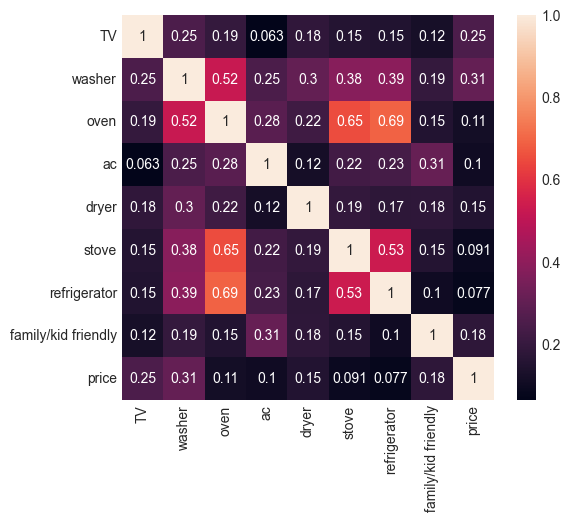

In [687]:
dfc = pd.DataFrame(df.corr(method="pearson")["price"])
dfc.reset_index(inplace=True)
dfc.columns = ["features", "correlation_with_price"]
dfc.sort_values("correlation_with_price", ascending=True)
df1 = dfc[dfc["correlation_with_price"] > 0]
cols=['TV', 'washer', 'oven', 'ac',
        'dryer', 'stove',
       'refrigerator','family/kid friendly','price']
df2= df[cols]
corr = df2.corr()
plt.rcParams.update({'figure.figsize':(6,5), 'figure.dpi':100})
sns.heatmap(corr, annot=True)

In [704]:
# Define the map centered on Edinburgh
m = folium.Map(location=[55.9533, -3.1883], zoom_start=12, tiles='cartodbpositron')

# Define the style function for the GeoJson layer
def style_function(feature):
    return {
        'fillOpacity': 0.2,
        'weight': 1,
    }

# Define the price range and the corresponding color map
min_price = df['log_price'].min()
max_price = df['log_price'].max()
color_map = linear.YlOrRd_09.scale(min_price, max_price)

# Add the GeoDataFrame boundaries to the map with the custom style function
folium.GeoJson(geodata, style_function=style_function).add_to(m)

# Add a marker for each listing with a color based on its price
for _, row in df.iterrows():
    color = color_map(row['log_price'])
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=0.5, fill_color=color, color=color, fill_opacity=0.6).add_to(m)

# Add the color map to the map as a legend
color_map.caption = 'Log Price (Log(USD))'
color_map.add_to(m)
m

In [705]:
df.rename(columns = {'neighbourhood_cleansed':'neighbourhood'}, inplace = True)

listings = df

# Group the listings by neighbourhood and count the number of listings per neighbourhood
neighbourhood_counts = listings.groupby('neighbourhood').size().reset_index(name='count')

# Calculate the average price per neighbourhood
neighbourhood_prices = listings.groupby('neighbourhood')['log_price'].median().reset_index(name='avg_price')

# Read the GeoJSON file with the neighbourhood boundaries
neighbourhoods = geodata

# Merge the neighbourhood_counts and neighbourhood_prices dataframes with the neighbourhoods GeoDataFrame
neighbourhoods = neighbourhoods.merge(neighbourhood_counts, on='neighbourhood')
neighbourhoods = neighbourhoods.merge(neighbourhood_prices, on='neighbourhood')

# Calculate the minimum and maximum average prices for the color scale
min_price = neighbourhood_prices['avg_price'].min()
max_price = neighbourhood_prices['avg_price'].max()

# Create the folium map centered at the mean coordinates of the neighbourhoods
map_center = [neighbourhoods.geometry.centroid.y.mean(), neighbourhoods.geometry.centroid.x.mean()]
folium_map = folium.Map(location=map_center, zoom_start=12, tiles='cartodbpositron')
def style_function(feature):
    return {
        'fillOpacity': 0.1,
        'weight': 1,
    }
folium.GeoJson(neighbourhoods, style_function=style_function).add_to(folium_map)

# Define the color scale
color_scale = folium.LinearColormap(['gray', 'gray'], vmin=min_price, vmax=max_price)

folium.Choropleth(
    geo_data = geodata,
    data = neighbourhoods,
    columns = ["neighbourhood", "avg_price"],
    key_on = "feature.properties.neighbourhood",
    fill_color="YlOrRd",
    fill_opacity=0.6,
    line_opacity=0.5,
    legend_name="Average Price (USD)",
).add_to(folium_map)

# Add the neighbourhood bubbles to the map
for _, row in neighbourhoods.iterrows():
    popup_text = f"{row['neighbourhood']} ({row['count']} listings, ${row['avg_price']:.0f}/night)"
    folium.Circle(
        location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
        radius=row['count'] * 1,
        color=color_scale(row['avg_price']),
        fill=False,
        fill_color=color_scale(row['avg_price']),
        fill_opacity=0.5,
        popup=popup_text,
        tooltip=popup_text
    ).add_to(folium_map)

# Add the color scale legend to the map
color_scale.caption = 'Price (USD)'
folium.LayerControl().add_to(m)

# Create a custom HTML legend
legend_html = """
<div style="position: fixed; bottom: 500px; left: 300px; z-index:9999; font-size: 20px; background-color:rgba(255, 255, 255, 0.5); padding: 10px; border-radius: 5px;">
    <p><strong>Legend</strong></p>
    <p><span style='color: Grey;'>&#9679; Number of Airbnb listings</span></p>
</div>
"""
# Add the legend to the map
folium_map.get_root().html.add_child(folium.Element(legend_html))


# Display the map
folium_map

C:\Users\rohit\AppData\Local\Temp\ipykernel_3524\3563649303.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [neighbourhoods.geometry.centroid.y.mean(), neighbourhoods.geometry.centroid.x.mean()]
C:\Users\rohit\AppData\Local\Temp\ipykernel_3524\3563649303.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [neighbourhoods.geometry.centroid.y.mean(), neighbourhoods.geometry.centroid.x.mean()]


C:\Users\rohit\AppData\Local\Temp\ipykernel_3524\3354706269.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


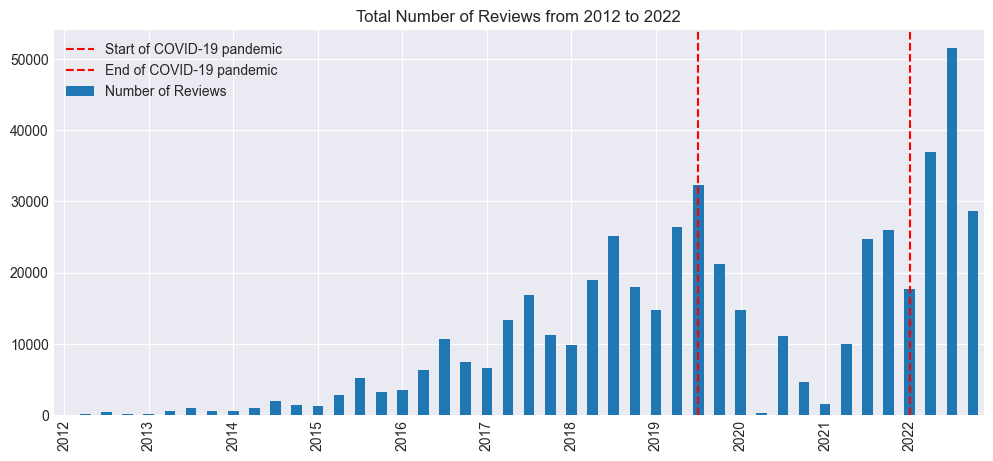

In [706]:
# convert the 'date' column to a pandas datetime object
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
plt.style.use("seaborn-darkgrid")

# filter the data to only include years from 2011 to 2022
reviews_df = reviews_df[(reviews_df['date'].dt.year >= 2012) & (reviews_df['date'].dt.year <= 2022)]

# group the data by year and quarter and compute the count of reviews for each quarter
grouped_data = reviews_df.groupby([reviews_df['date'].dt.year, pd.PeriodIndex(reviews_df['date'], freq='Q').to_timestamp()]).count()

# create a bar plot of the grouped data
fig, ax = plt.subplots()
grouped_data['id'].plot(kind='bar', label='Number of Reviews', ax=ax)

# set the x-axis label
ax.set_xlabel('')

# set the y-axis label
ax.set_ylabel('')

# set the title of the plot
ax.set_title('Total Number of Reviews from 2012 to 2022')

# Replace the x-axis tick labels with your own
x_ticks = range(0, len(grouped_data), 4)
x_tick_labels = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

# add vertical lines for the start and end of the COVID-19 pandemic
# add vertical lines for the start and end of the COVID-19 pandemic
plt.axvline(30, color='red', linestyle='--', label='Start of COVID-19 pandemic')
plt.axvline(40, color='red', linestyle='--', label='End of COVID-19 pandemic')

plt.legend()

# show the plot
plt.show()

In [707]:
df = df.groupby("neighbourhood").filter(lambda x: len(x)>20)

df['neighbourhood_cleansed'] = df['neighbourhood']

In [708]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the earth in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

landmark_lat = 55.9531
landmark_long = -3.1882

In [709]:
df['distance_to_landmark'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], landmark_lat, landmark_long), axis=1)

In [710]:
df['distance_to_landmark'] = df['distance_to_landmark'].abs()
X = df['distance_to_landmark'].values.reshape(-1,1)
y = df['log_price'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

residuals = y_test - y_pred

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
p_value = model.f_pvalue

p_value

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     187.3
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           6.71e-42
Time:                        10:56:45   Log-Likelihood:                -3759.4
No. Observations:                5071   AIC:                             7523.
Df Residuals:                    5069   BIC:                             7536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8892      0.013    384.082      0.0

In [711]:
X = df['distance_to_landmark'].values.reshape(-1, 1)
y = df['log_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

residuals = y_test - y_pred


# Split residuals into two groups: those with distance to landmark < 5 km and those with distance to landmark >= 5 km
residuals_close = residuals[X_test.flatten() < 5]
residuals_far = residuals[X_test.flatten() >= 5]

# Calculate the mean and standard deviation of each group
mean_close = residuals_close.mean()
std_close = residuals_close.std()
mean_far = residuals_far.mean()
std_far = residuals_far.std()

# Perform a two-sample t-test to compare the means of the two groups
t_stat, p_value = ttest_ind(residuals_close, residuals_far, equal_var=False)

p_value

0.7263674582291478

In [712]:
X = df['distance_to_landmark'].values.reshape(-1, 1)
y = df['log_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = DecisionTreeRegressor(max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

residuals = y_test - y_pred

from scipy.stats import ttest_ind

# Split residuals into two groups: those with distance to landmark < 5 km and those with distance to landmark >= 5 km
residuals_close = residuals[X_test.flatten() < 5]
residuals_far = residuals[X_test.flatten() >= 5]

# Calculate the mean and standard deviation of each group
mean_close = residuals_close.mean()
std_close = residuals_close.std()
mean_far = residuals_far.mean()
std_far = residuals_far.std()

# Perform a two-sample t-test to compare the means of the two groups
t_stat, p_value = ttest_ind(residuals_close, residuals_far, equal_var=False)

p_value

0.9978362865619779

In [717]:

df=df.drop("availability_30", axis=1)
df=df.drop("availability_60", axis=1)
df=df.drop("availability_365", axis=1)
df=df.drop("neighbourhood", axis=1)
df=df.drop("latitude", axis=1)
df=df.drop("longitude", axis=1)
df=df.drop("distance_to_landmark", axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5071 entries, 0 to 7388
Data columns (total 87 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   neighbourhood                      5071 non-null   object 
 1   accommodates                       5071 non-null   int64  
 2   bedrooms                           5071 non-null   float64
 3   beds                               5071 non-null   float64
 4   minimum_nights                     5071 non-null   int64  
 5   availability_90                    5071 non-null   int64  
 6   latitude                           5071 non-null   float64
 7   longitude                          5071 non-null   float64
 8   number_of_reviews                  5071 non-null   int64  
 9   reviews_per_month                  5071 non-null   float64
 10  review_scores_rating               5071 non-null   float64
 11  review_scores_accuracy             5071 non-null   float

# Models #

In [666]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

target = df["log_price"]
features = df.drop(["price","log_price"], axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.3, random_state = 1)

sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train))
X_test_sc = pd.DataFrame(sc.transform(X_test))

In [667]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [668]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
folds  = 5
score_calc = 'neg_mean_squared_error'

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False],  'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv = folds, verbose = 1 , scoring = score_calc)
grid_linear.fit(X_train, Y_train)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.3422020030566572
{'copy_X': True, 'fit_intercept': True}
LinearRegression()


In [669]:
LR = LinearRegression()
LR.fit(X_train, Y_train)
pred_linreg_all = LR.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()
r2_score(Y_test, pred_linreg_all)

0.5815117673014099

In [670]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_rf.fit(X_train, Y_train)

sc_rf = get_best_score(grid_rf)
pred_rf = grid_rf.predict(X_test)
r2_score(Y_test, pred_rf)

0.3289494287729054
{'min_samples_split': 4, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(min_samples_split=4, random_state=5)


0.6053289740195735

C:\Users\rohit\AppData\Local\Temp\ipykernel_3524\5807818.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


Text(0.5, 1.0, 'Feature Importance (Random Forest)')

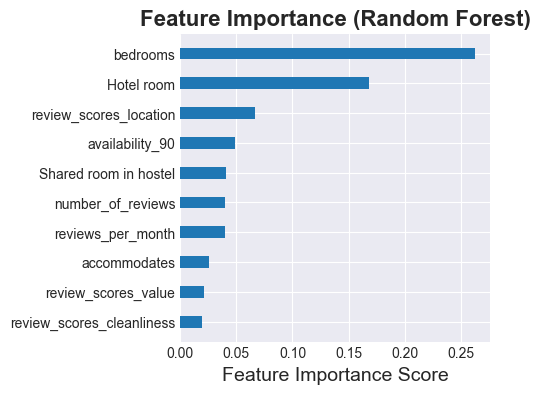

In [675]:
features = df.columns
score = grid_rf.best_estimator_.feature_importances_
features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(4,4))
plt.barh(features_sorted[:10][::-1], score_sorted[:10][::-1], height=0.4)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance (Random Forest)", fontsize=16, fontweight="bold")

In [672]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,              
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_knn.fit(X_train_sc, Y_train)
sc_knn = get_best_score(grid_knn)
pred_knn = grid_knn.predict(X_test_sc)
r2_score(Y_test, pred_knn)

0.3692487731977242
{'algorithm': 'ball_tree', 'n_neighbors': 15, 'weights': 'distance'}
KNeighborsRegressor(algorithm='ball_tree', n_neighbors=15, weights='distance')


0.5073149806989885

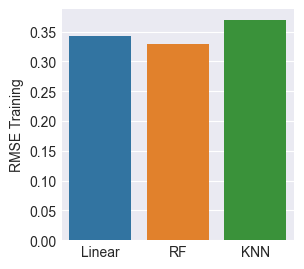

In [673]:
#Comparing rmse of models
list_scores = [sc_linear, sc_rf, sc_knn]
list_predictions = [pred_linreg_all, pred_rf, pred_knn]
list_regressors = ['Linear', 'RF','KNN']
fig, ax = plt.subplots()
fig.set_size_inches(3,3)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE Training')
plt.show()

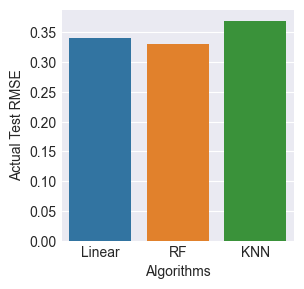

In [674]:
#Comparing rmse of models over testing data
from sklearn.metrics import mean_squared_error
errors = []
for pred in list_predictions:
    errors.append(mean_squared_error(Y_test, pred, squared=False))
    
regressors = ['Linear','RF','KNN']
fig, ax = plt.subplots()
fig.set_size_inches(3,3)
sns.barplot(x = regressors, y = errors, ax=ax)
plt.ylabel('Actual Test RMSE')
plt.xlabel('Algorithms')
plt.show()

In [581]:
sampled_df = df.sample(n=100, random_state=100)
tv = sampled_df[sampled_df['TV'] >=1]['log_price']# log price?
no_tv = sampled_df[sampled_df['TV']==0]['log_price']
print(len(tv))
print(len(no_tv))
import scipy.stats
from scipy.stats import t
from scipy.stats import ttest_ind
t_stat,pvalue=ttest_ind(tv, no_tv)
print('t-statistics:',t_stat, '\np-value:', pvalue)

 
# To find the T critical value
scipy.stats.t.ppf(q=1-.05,df=98)

79
21
t-statistics: 3.2435856518108257 
p-value: 0.0016145262798862646


1.6605512170440568

In [583]:
sampled_df = df.sample(n=100, random_state=100)
washer = sampled_df[sampled_df['washer']>=1]['log_price']
no_washer = sampled_df[sampled_df['washer']==0]['log_price']
print(len(washer))
print(len(no_washer))
import scipy.stats
from scipy.stats import t
from scipy.stats import ttest_ind
t_stat,pvalue=ttest_ind(washer, no_washer)
print('t-statistics:',t_stat, '\np-value:', pvalue)

 
# To find the T critical value
scipy.stats.t.ppf(q=1-.05,df=100)

87
13
t-statistics: 2.422042501570691 
p-value: 0.017271579628083268


1.66023432606575

In [589]:
sampled_df = df.sample(n=100, random_state=100)
kid_friendly = sampled_df[sampled_df['family/kid friendly']>=1]['log_price']
no_kid_friendly = sampled_df[sampled_df['family/kid friendly']==0]['log_price']
print(len(kid_friendly))
print(len(no_kid_friendly))
import scipy.stats
from scipy.stats import t
from scipy.stats import ttest_ind
t_stat,pvalue=ttest_ind(kid_friendly, no_kid_friendly)
print('t-statistics:',t_stat, '\np-value:', pvalue)

 
# To find the T critical value
scipy.stats.t.ppf(q=1-.05,df=100)

24
76
t-statistics: 2.6277130352942657 
p-value: 0.009978584346046244


1.66023432606575

C:\Users\rohit\AppData\Local\Temp\ipykernel_3524\3135721208.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


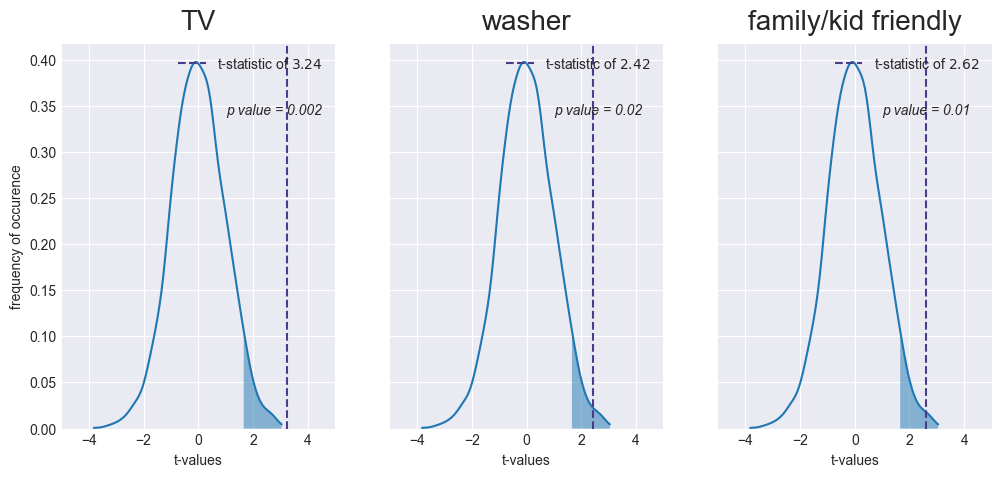

In [688]:
import scipy.stats as stats
plt.style.use("seaborn-darkgrid")
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
dist= np.random.standard_t(100, size=3000)
kde = stats.gaussian_kde(dist)
# plot complete kde curve as line
pos = np.linspace(dist.min(), dist.max(), 101)
fig, axes = plt.subplots(1, 3) 
axes[0].plot(pos, kde(pos))
# plot shaded kde only right of x=1.66
shade = np.linspace(1.66,dist.max(), 101)
axes[0].fill_between(shade,kde(shade), alpha=0.5)
axes[0].axvline(x=3.24, color='darkslateblue', linestyle='--', label='t-statistic of $3.24$')
axes[0].set_title("TV", y=1.015, fontsize=20)
axes[0].text(1, 0.34, 'p value = 0.002', style='italic')
axes[0].set_xlim([-5, 5])
axes[0].set_ylim([0, None])
# axes[0].ylim(0,None)
# axes[0].xlim(-5, 5)
axes[0].legend(loc=1)
axes[1].plot(pos, kde(pos))
# plot shaded kde only right of x=1.66
shade = np.linspace(1.66,dist.max(), 101)
axes[1].fill_between(shade,kde(shade), alpha=0.5)
axes[1].axvline(x=2.42, color='darkslateblue', linestyle='--', label='t-statistic of $2.42$')
axes[1].set_title("washer", y=1.015, fontsize=20)
axes[1].text(1, 0.34, 'p value = 0.02', style='italic')
axes[1].set_xlim([-5, 5])
axes[1].set_ylim([0, None])
axes[1].legend(loc=1)
axes[2].plot(pos, kde(pos))
# plot shaded kde only right of x=1.66
shade = np.linspace(1.66,dist.max(), 101)
axes[2].fill_between(shade,kde(shade), alpha=0.5)
axes[2].axvline(x=2.62, color='darkslateblue', linestyle='--', label='t-statistic of $2.62$')
axes[2].set_title("family/kid friendly", y=1.015, fontsize=20)
axes[2].text(1, 0.34, 'p value = 0.01', style='italic')
axes[2].set_xlim([-5, 5])
axes[2].set_ylim([0, None])
axes[2].legend(loc=1)
for ax in axes.flat:
    ax.set(xlabel='t-values', ylabel='frequency of occurence')
for ax in axes.flat:
    ax.label_outer()

plt.show()